In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # or "3" to show only errors
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

data ===> type: <class 'numpy.ndarray'> | shape: (2520,) | dtype: [('age', 'i1')]
Min:  15
Max:  90
Mean:  63.28452380952381


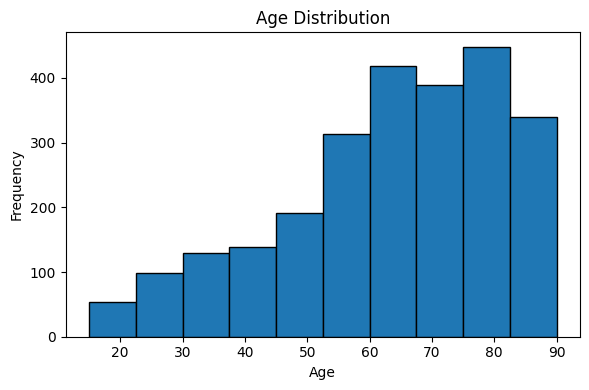

In [2]:
# Load data
data_path = '/Users/chetankumar/Library/CloudStorage/OneDrive-OldDominionUniversity/jlab_test/data/eICU_age.npy'
data = np.load(data_path)
print(f'data ===> type: {type(data)} | shape: {data.shape} | dtype: {data.dtype}')

data = data['age']
print("Min: ", data.min())
print("Max: ", data.max())
print("Mean: ", data.mean())

# Plot data distribution
plt.figure(figsize=(6, 4))
plt.hist(data, edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [3]:
# Normalize data
data = data.reshape(-1, 1)

scaler = StandardScaler()
data_norm = scaler.fit_transform(data).flatten()

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(data_norm).shuffle(len(data_norm)).batch(128)

In [5]:
class GAN(tf.keras.Model):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim

        # Generator
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(latent_dim,)),
            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Dense(1, activation='linear')
        ])

        # Descriminator
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(1,)),
            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        self.bce = tf.keras.losses.BinaryCrossentropy()
        self.g_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
        self.d_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

    @tf.function
    def train_step(self, real_batch):
        batch_size = tf.shape(real_batch)[0]
        real_batch = tf.reshape(real_batch, (batch_size, 1))

        # Train discriminator
        noise = tf.random.normal((batch_size, self.latent_dim))

        with tf.GradientTape() as d_tape:
            generated = self.generator(noise, training=True)

            real_logits = self.discriminator(real_batch, training=True)
            generated_logits = self.discriminator(generated, training=True) 

            d_loss_real = self.bce(tf.ones_like(real_logits), real_logits)
            d_loss_generated = self.bce(tf.zeros_like(generated_logits), generated_logits)
            d_loss = d_loss_real + d_loss_generated

        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # Train generator
        noise = tf.random.normal((batch_size, self.latent_dim))
        with tf.GradientTape() as g_tape:
            generated = self.generator(noise, training=True)
            generated_logits = self.discriminator(generated, training=True)
            g_loss = self.bce(tf.ones_like(generated_logits), generated_logits)

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return d_loss, g_loss
    
    def sample(self, n):
        noise = tf.random.normal((n, self.latent_dim))
        return self.generator(noise, training=False).numpy().flatten()        

In [14]:
model = GAN()
epochs = 1500
d_loss_list = []
g_loss_list = []
for epoch in range(epochs):
    d_losses = 0
    g_losses = 0
    for real_batch in dataset:
        d_loss, g_loss = model.train_step(real_batch)
        d_losses += d_loss
        g_losses += g_loss
    d_loss = np.mean(d_losses)
    g_loss = np.mean(g_losses)
    d_loss_list.append(d_loss)
    g_loss_list.append(g_loss)
    
    if epoch % 200 == 0:
        print(f"epoch:{epoch}, d_loss:{d_loss}, g_loss:{g_loss}")

epoch:0, d_loss:27.618576049804688, g_loss:13.644925117492676
epoch:200, d_loss:27.7196102142334, g_loss:13.793320655822754
epoch:400, d_loss:27.693485260009766, g_loss:13.889546394348145
epoch:600, d_loss:27.68178939819336, g_loss:13.905235290527344
epoch:800, d_loss:27.691858291625977, g_loss:13.911103248596191
epoch:1000, d_loss:27.713720321655273, g_loss:13.94479751586914
epoch:1200, d_loss:27.701210021972656, g_loss:13.925508499145508
epoch:1400, d_loss:27.733104705810547, g_loss:13.925190925598145


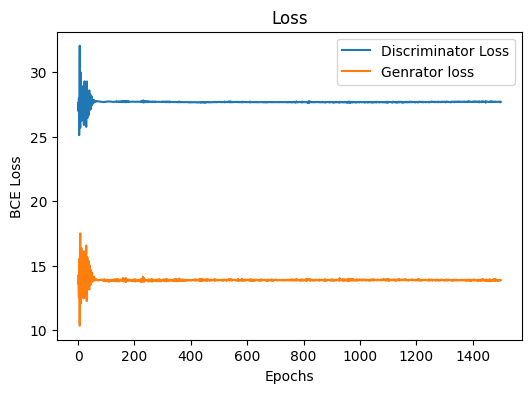

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(d_loss_list, label='Discriminator Loss')
plt.plot(g_loss_list, label='Genrator loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.title('Loss')
plt.legend()

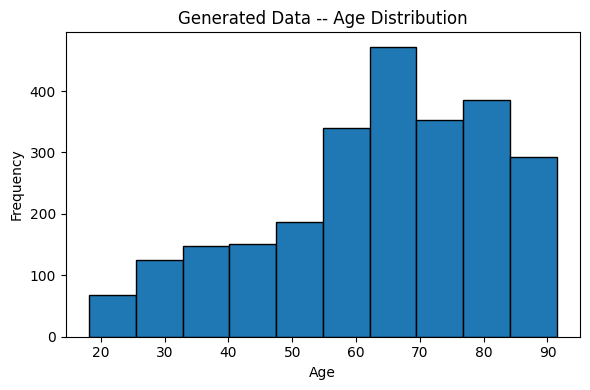

In [16]:
# Generate data
samples_scaled = model.sample(2520).reshape(-1, 1)
samples = scaler.inverse_transform(samples_scaled).flatten()

plt.figure(figsize=(6, 4))
plt.hist(samples, edgecolor='black')
plt.title("Generated Data -- Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()